In [61]:
# Kernel -> py311ml
# Imports aquí ->
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import shap
from shap import SamplingExplainer
from scipy.stats import mannwhitneyu, pointbiserialr

from category_encoders import BinaryEncoder, CountEncoder, OrdinalEncoder, TargetEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report,
                             confusion_matrix, recall_score,
                             roc_auc_score, roc_curve)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     StratifiedShuffleSplit, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, LabelEncoder,
                                   MinMaxScaler, OneHotEncoder,
                                   OrdinalEncoder as SklearnOrdinalEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [62]:
# import importlib
# import subprocess
# import sys

# def ensure_package(pkg_name):
#     if importlib.util.find_spec(pkg_name) is None:
#         print(f"Instalando {pkg_name}…")
#         subprocess.check_call([sys.executable, "-m", "pip", "install", pkg_name])
#     else:
#         print(f"{pkg_name} ya está instalado.")

# ensure_package("skrebate")
# from skrebate import ReliefF

Primeramente vamos a leer el archivo y comprobar las variables, con sus tipos de dato

In [63]:
data = pd.read_csv('src/adult.data', header=None, sep=',\s', na_values=["?"], engine='python')
data.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                   'hours-per-week', 'native-country', 'income']


def check_df(dataframe, head=5):
    print("------------ Shape ------------")
    print(dataframe.shape)
    print("------------ Types ------------")
    print(dataframe.dtypes)
    
check_df(data)

------------ Shape ------------
(32561, 15)
------------ Types ------------
age                int64
workclass         object
final-weight       int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


Comprobamos que variables contienen valores perdidos 

In [64]:
data.isnull().sum()

age                  0
workclass         1836
final-weight         0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

Ahora con ayuda de graficas, visualizamos la distribucion de las variables anteriores


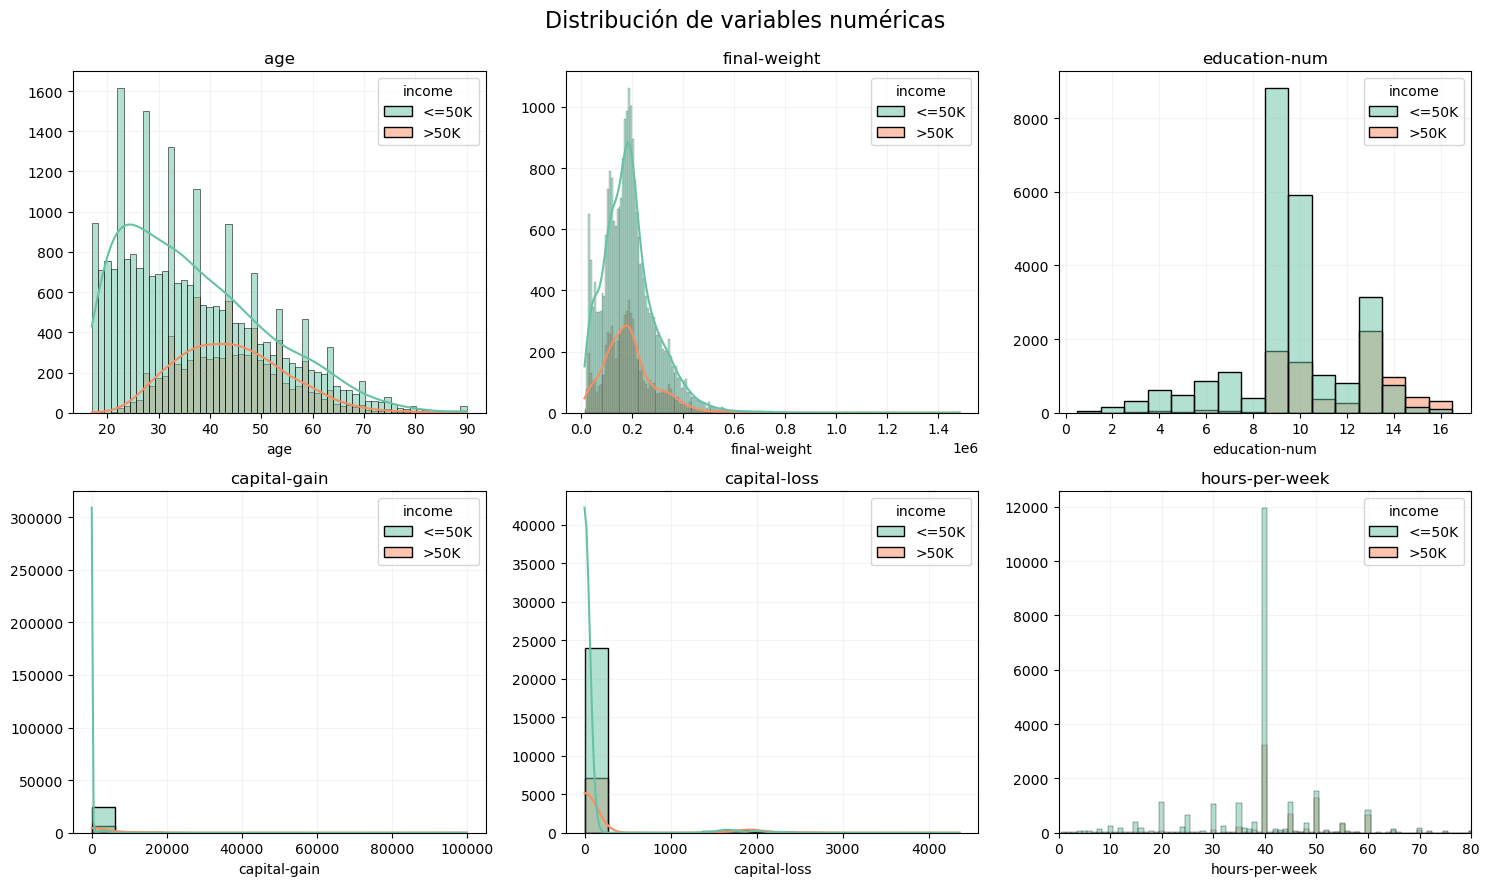

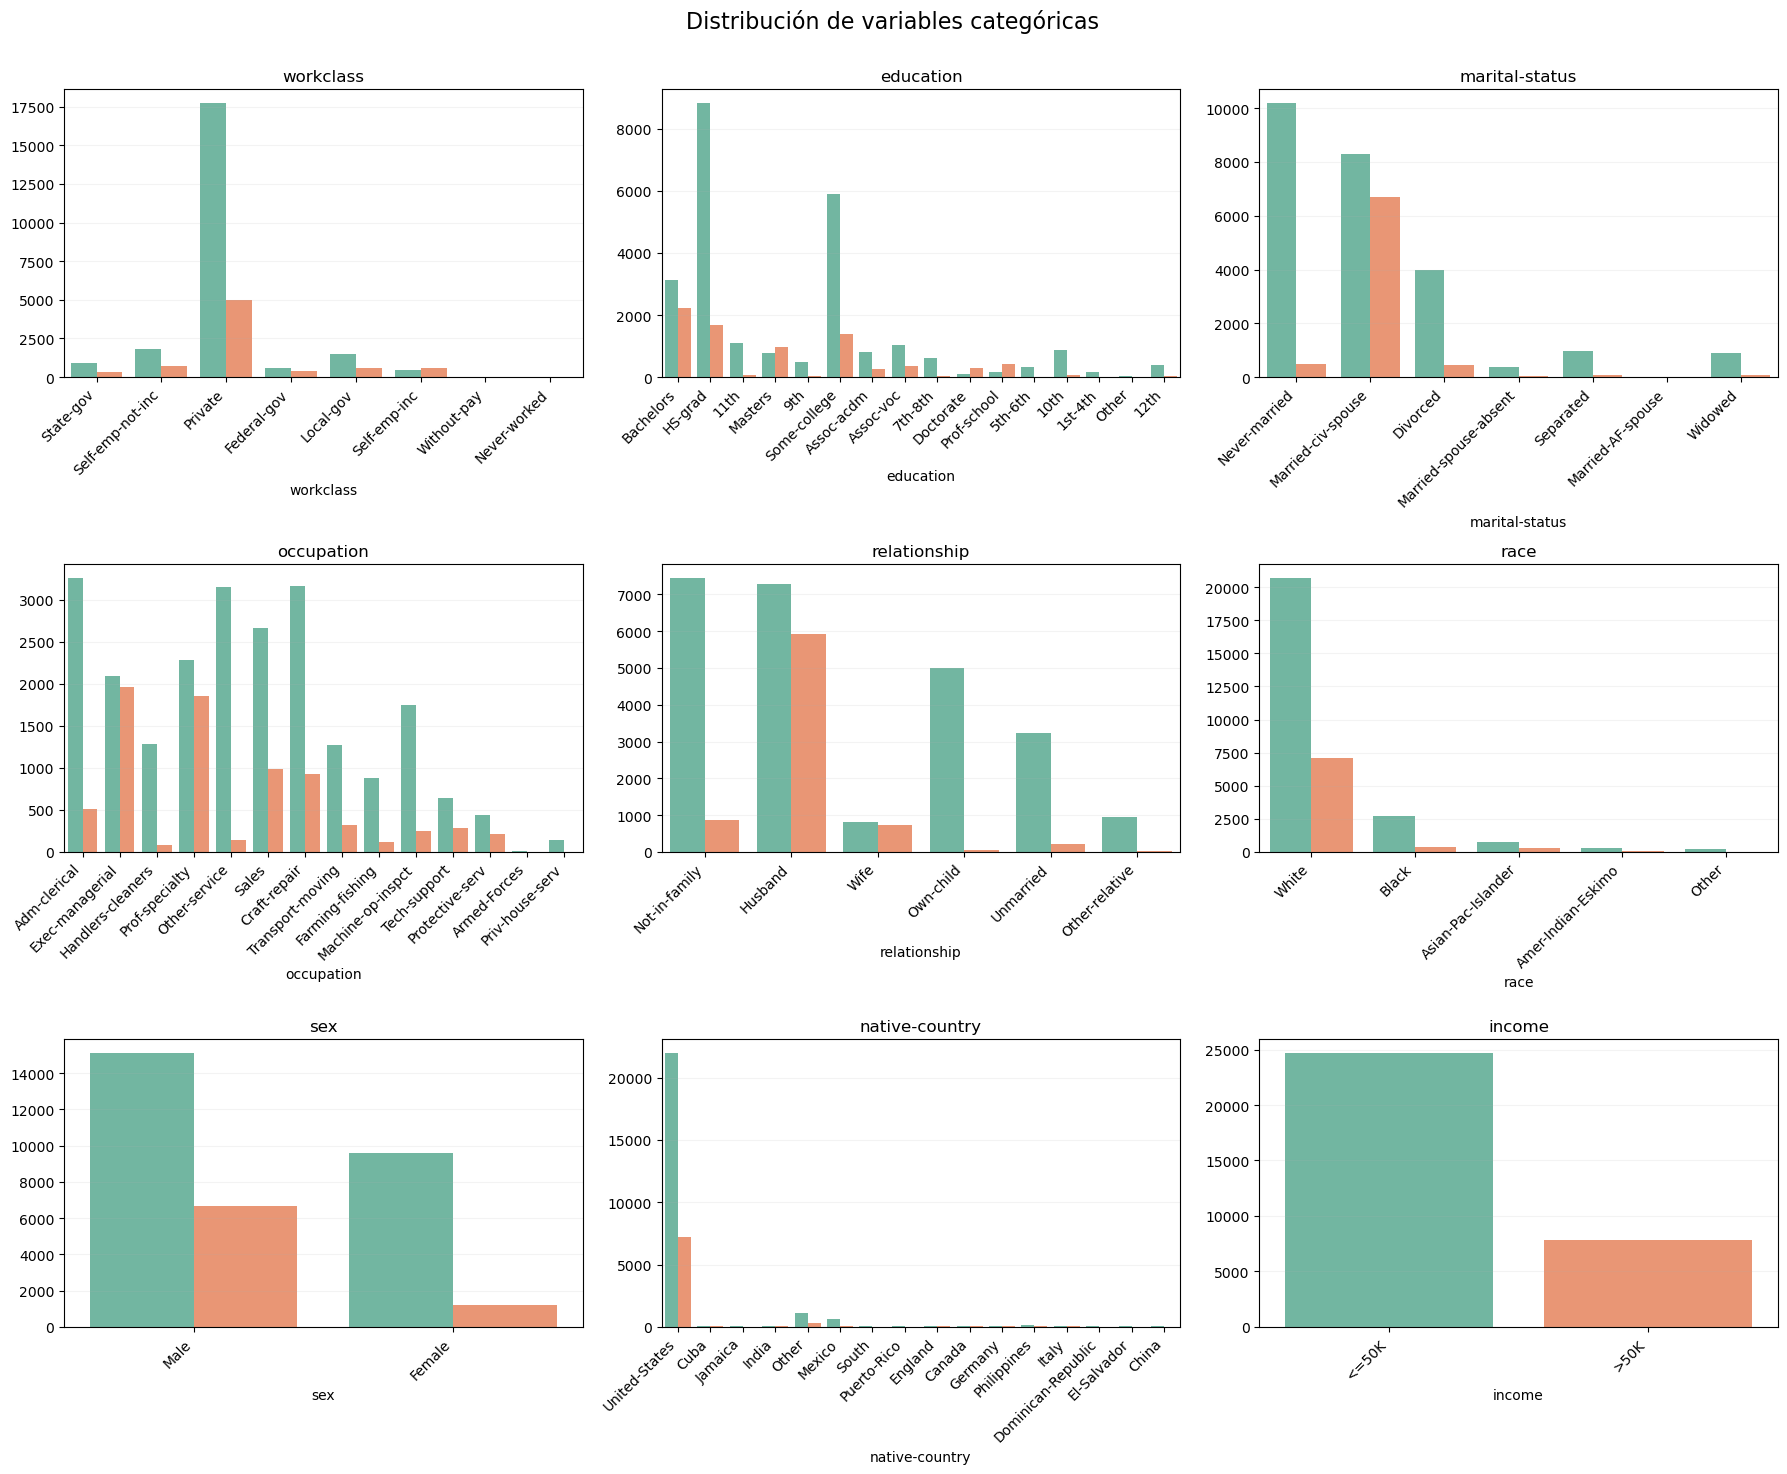

In [65]:
# NUMÉRICAS
numeric_cols  = data.select_dtypes(include=["int64", "float64"]).columns
discrete_vars = ["education-num", "hours-per-week"]   # tratadas como discretas
plt.style.use("default")
palette = "Set2"

n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4.5*n_rows))

for ax, col in zip(axes.flat, numeric_cols):
    discrete_flag = col in discrete_vars

    sns.histplot(
        x=data[col],
        hue=data["income"],
        palette=palette,
        alpha=.5,
        ax=ax,
        kde=False if discrete_flag else True,
        bins="auto",
        discrete=discrete_flag,
        kde_kws={"bw_adjust": 1.5} if not discrete_flag else None,
    )
    if col == "hours-per-week":
        ax.set_xlim(0, 80)

    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("")
    ax.grid(True, alpha=.15)

# desactiva ejes vacíos si los hubiera
for ax in axes.flat[len(numeric_cols):]:
    ax.set_visible(False)

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Distribución de variables numéricas", fontsize=16)
plt.show()

#CATEGÓRICAS
cat_cols = data.select_dtypes(include="object").columns
TOP_N    = 15

n_cols_c = 3
n_rows_c = (len(cat_cols) + n_cols_c - 1) // n_cols_c
fig_c, axes_c = plt.subplots(n_rows_c, n_cols_c, figsize=(6*n_cols_c, 5*n_rows_c))

def _wrap(label):
    if len(label) > 15:
        return label.replace("-", "\n") if "-" in label else textwrap.fill(label, 9)
    return label

for ax, col in zip(axes_c.flat, cat_cols):
    freq = data[col].value_counts()
    if len(freq) > TOP_N:
        top_vals = freq.index[:TOP_N]
        data_plot = data.copy()
        data_plot[col] = data_plot[col].where(
            data_plot[col].isin(top_vals), other="Other"
        )
    else:
        data_plot = data

    sns.countplot(
        data=data_plot,
        x=col,
        hue="income",
        palette=palette,
        ax=ax,
    )
    ax.set_title(col)
    ax.set_ylabel("")
    for lbl in ax.get_xticklabels():
        lbl.set_text(_wrap(lbl.get_text()))
        lbl.set_rotation(45)
        lbl.set_ha("right")

    if ax.legend_:
        ax.legend_.remove()
    ax.grid(True, axis="y", alpha=.15)

for ax in axes_c.flat[len(cat_cols):]:
    ax.set_visible(False)

fig_c.tight_layout(rect=[0, 0, 1, 0.95])
fig_c.suptitle("Distribución de variables categóricas", fontsize=16)
plt.show()


PAIR-PLOT con variables numéricas 

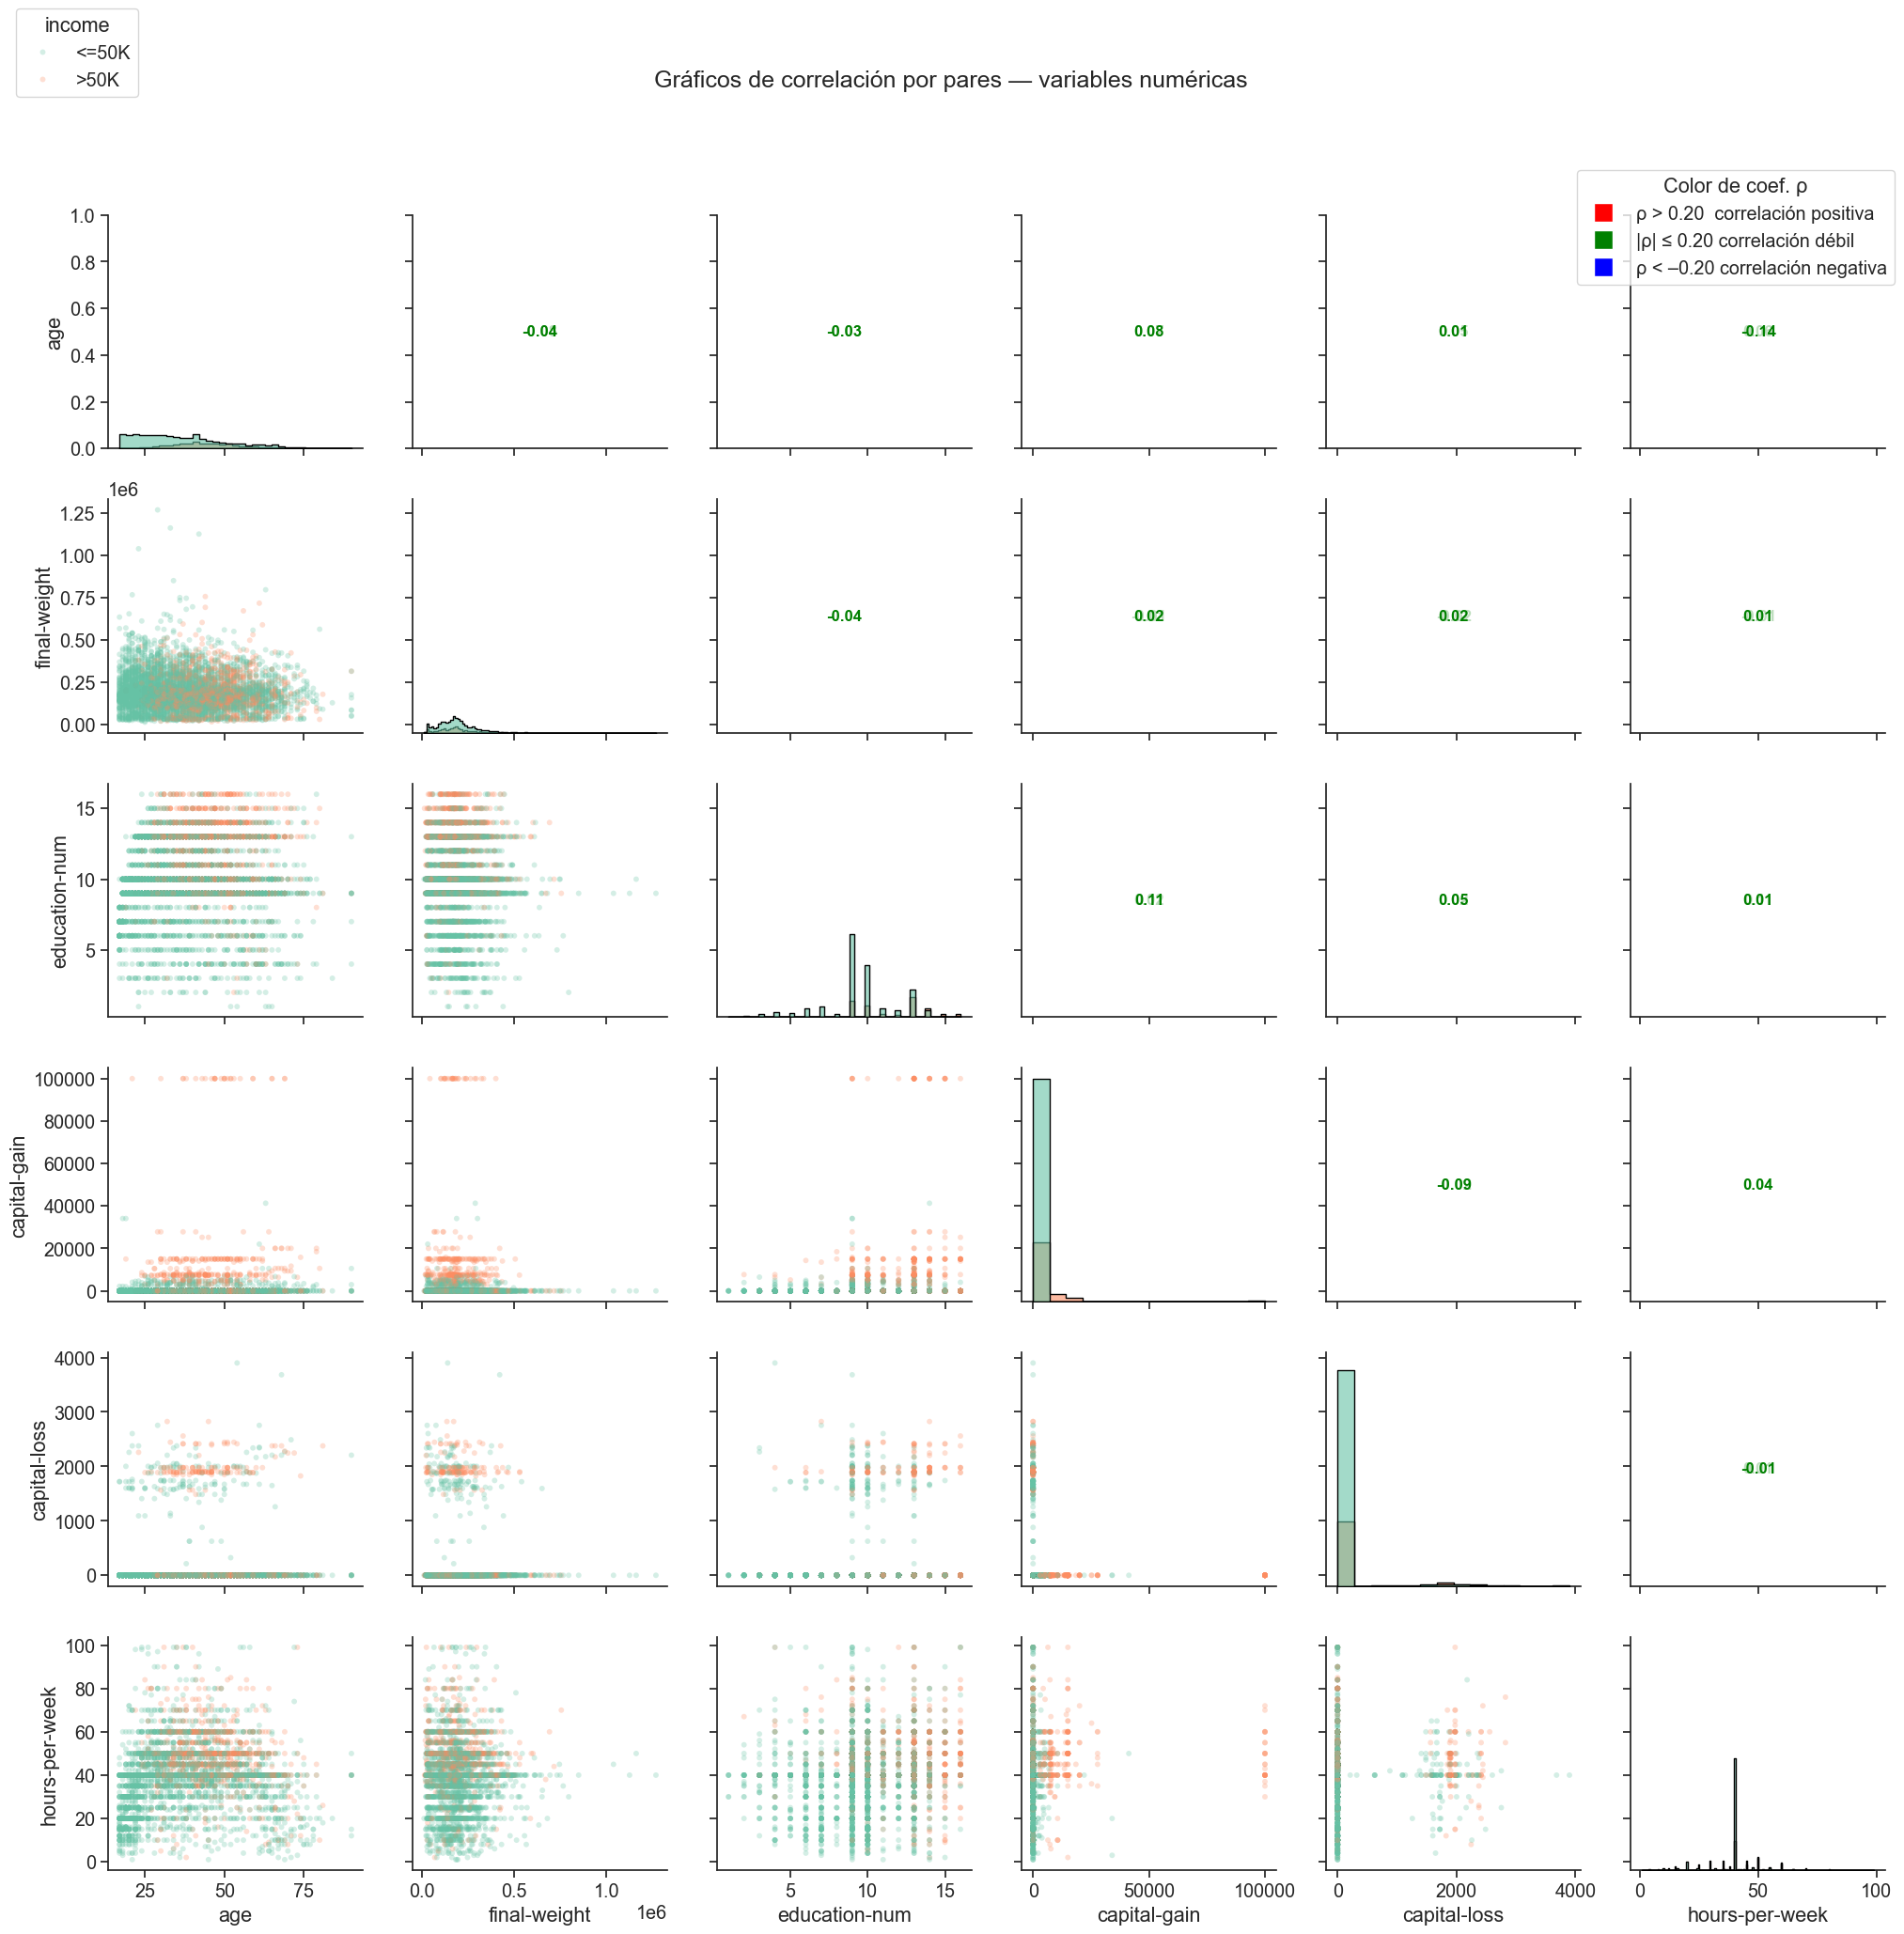

In [66]:
sns.set_theme(style="ticks", font_scale=1.3)
num_cols = ["age", "final-weight", "education-num",
            "capital-gain", "capital-loss", "hours-per-week"]
df = data[num_cols + ["income"]].sample(min(6000, len(data)), random_state=7)

g = sns.PairGrid(df, vars=num_cols, hue="income",
                 palette=palette, height=3.2, aspect=1)

g.map_lower(sns.scatterplot, alpha=.28, s=18, linewidth=0)
g.map_diag(sns.histplot, element="step", bins="auto",
           alpha=.6, edgecolor="black")

def annotate_corr(x, y, **kws):
    r = np.corrcoef(x, y)[0, 1]
    if abs(r) < 0.005:          # ❶ omite “0.00”
        return
    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    color = "red" if r > .20 else "blue" if r < -.20 else "green"
    ax.text(.5, .5, f"{r:.2f}", ha='center', va='center',
            transform=ax.transAxes, fontsize=12, weight='bold',
            color=color,
            bbox=dict(boxstyle="round,pad=0.25",
                      fc="white", ec="none", alpha=.75))
    ax.set_xlim(xlim); ax.set_ylim(ylim)

g.add_legend(title="income", frameon=True,
             bbox_to_anchor=(0.01, 1.02), loc="lower left")


g.map_upper(annotate_corr)

# Leyenda
legend_elems = [
    Line2D([0], [0], marker='s', color='white',
           label='ρ > 0.20  correlación positiva', markerfacecolor='red', markersize=15),
    Line2D([0], [0], marker='s', color='white',
           label='|ρ| ≤ 0.20 correlación débil', markerfacecolor='green', markersize=15),
    Line2D([0], [0], marker='s', color='white',
           label='ρ < –0.20 correlación negativa', markerfacecolor='blue', markersize=15)
]
g.fig.legend(handles=legend_elems, title="Color de coef. ρ",
             bbox_to_anchor=(0.995, 0.99), loc="upper right", frameon=True)

g.fig.suptitle("Gráficos de correlación por pares — variables numéricas",
               fontsize=18, y=1.04)

plt.tight_layout()
plt.show()


Correlación punto-biserial entre cada variable numérica e income

In [67]:
num_cols = ["age", "final-weight", "education-num",
            "capital-gain", "capital-loss", "hours-per-week"]

r_pb = {col: pointbiserialr(data["income"].eq(">50K").astype(int), data[col])[0]
         for col in num_cols}

pd.Series(r_pb).sort_values(ascending=False)


education-num     0.335154
age               0.234037
hours-per-week    0.229689
capital-gain      0.223329
capital-loss      0.150526
final-weight     -0.009463
dtype: float64

OUTLIERS CON MEDIANA

In [68]:

class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        # IQRs = Xaux.quantile(0.75) - Xaux.quantile(0.25)
        IQRs = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = Xaux < limiteInf
        mayores = Xaux > limiteSup
        valores = np.logical_or(menores, mayores)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        out_total = 0
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = valores[c]
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                Xaux.loc[indices, c] = Xaux[c].median()
                out_total += len(indices)
        # Se devuelve el DataFrame modificado
        # print("Total de outliers: ", out_total)
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    # Constructor de la clase
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.mean = X.mean()
        self.std = X.std()
        self.median = X.median()
        return self
    
    def transform(self, X):
        Xaux = X.copy()
        out_total = 0
        for c in X.columns:
            # Se calculan los límites inferiores y superiores
            limiteInf = self.mean[c] - self.k * self.std[c]
            limiteSup = self.mean[c] + self.k * self.std[c]
            # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)
            menores = Xaux[c] < limiteInf
            mayores = Xaux[c] > limiteSup
            valores = np.logical_or(menores, mayores)
            # Si hay outliers
            if valores.any():
                # Los sustituimos por la mediana
                Xaux.loc[valores, c] = self.median[c]
                out_total += len(valores)
        # print("Total de outliers: " , out_total)
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def get_params(self, deep=True):
        return {"k": self.k}

OUTLIERS CON MEDIA

In [69]:

class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        # Creamos una copia del DataFrame X para no perder los datos originales
        Xaux = X.copy()
        # Se calcula el IQR de cada variable
        # IQRs = Xaux.quantile(0.75) - Xaux.quantile(0.25)
        IQRs = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        # Se calculan los límites inferiores y superiores   
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs
        # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)  
        menores = Xaux < limiteInf
        mayores = Xaux > limiteSup
        valores = np.logical_or(menores, mayores)
        # Se recorren las variables para detectar outliers y tratarlos (sustituir por la mediana de la variable)
        out_total = 0
        for c in self.columns:
            # obtenemos la lista de booleanos correspondientes a si los valores de los ejemplos son outliers o no para la variable c
            indices = valores[c]
            # Si hay outliers
            if indices.any():
                # Los sustituimos por la mediana
                Xaux.loc[indices, c] = Xaux[c].mean()
                out_total += len(indices)
        # Se devuelve el DataFrame modificado
        # print("Total de outliers: ", out_total)
        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    # Constructor de la clase
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.mean = X.mean()
        self.std = X.std()
        self.median = X.median()
        return self
    
    def transform(self, X):
        Xaux = X.copy()
        out_total = 0
        for c in X.columns:
            # Se calculan los límites inferiores y superiores
            limiteInf = self.mean[c] - self.k * self.std[c]
            limiteSup = self.mean[c] + self.k * self.std[c]
            # Se comprueba qué elementos están por encima y por debajo de dichos límites (máscaras de booleanos)
            menores = Xaux[c] < limiteInf
            mayores = Xaux[c] > limiteSup
            valores = np.logical_or(menores, mayores)
            # Si hay outliers
            if valores.any():
                # Los sustituimos por la mediana
                Xaux.loc[valores, c] = self.mean[c]
                out_total += len(valores)
        # print("Total de outliers: " , out_total)
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    def get_params(self, deep=True):
        return {"k": self.k}

OUTLIERS CON LIMITE SUPERIOR - INFERIOR

In [70]:
class OutlierDetecion_treatment_IQR(TransformerMixin):

    # Constructor de la clase
    def __init__(self, k=1.5, columns=None):
        self.k = k
        self.columns = columns
    
    # Método fit
    def fit(self, X, y=None):
        # Transformamos X a DataFrame por si llega un array de Numpy (para compatibilidad en la Pipeline)
        X = pd.DataFrame(X)
        if self.columns == None:
            # Si no se determinan variables en el constructor si tratan todas
            self.columns = X.columns
        self.stats = X.describe(percentiles=[0.25, 0.75])
        # Devolvemos el propio objeto modificado
        return self

    # Método transform
    def transform(self, X):
        X = pd.DataFrame(X)
        Xaux = X.copy()

        # Estadísticos guardados en fit
        IQRs      = self.stats.loc["75%", :] - self.stats.loc["25%", :]
        limiteInf = self.stats.loc["25%", :] - self.k * IQRs
        limiteSup = self.stats.loc["75%", :] + self.k * IQRs

        # Para cada columna, winsorizamos
        for c in self.columns:
            mask_low  = Xaux[c] < limiteInf[c]
            mask_high = Xaux[c] > limiteSup[c]
            if mask_low.any():
                Xaux.loc[mask_low,  c] = limiteInf[c]
            if mask_high.any():
                Xaux.loc[mask_high, c] = limiteSup[c]

        return Xaux
    
    # Método para asignar los valores de los híper-parámetros y que, de este modo, 
        # podamos aplicar GridSearchCV sobre un objeto de esta clase
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    # Método para obtener los valores de los híper-parámetros que queramos del modelo (lo usa GridSearchCV al mostrar la mejor configuración)
    def get_params(self, deep=True):
        # Devolvemos los valores de los híper-parámetros del método de preparación de datos
        return {"k": self.k}
    
    from sklearn.base import TransformerMixin

class OutlierDetecion_treatment_MeanStd(TransformerMixin):
    def __init__(self, k=2):
        self.k = k

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        # Calculamos y guardamos media y desviación por columna
        self.mean_ = X.mean()
        self.std_  = X.std()
        return self
    
    def transform(self, X):
        Xaux = pd.DataFrame(X).copy()
        # Cálculo de límites por columna
        limiteInf = self.mean_ - self.k * self.std_
        limiteSup = self.mean_ + self.k * self.std_
        
        # Winsorización
        for c in Xaux.columns:
            # Máscaras
            mask_low  = Xaux[c] < limiteInf[c]
            mask_high = Xaux[c] > limiteSup[c]
            # Sustitución por límites
            if mask_low.any():
                Xaux.loc[mask_low,  c] = limiteInf[c]
            if mask_high.any():
                Xaux.loc[mask_high, c] = limiteSup[c]
        
        return Xaux
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def get_params(self, deep=True):
        return {"k": self.k}


Version para usar con column transformer y meter este paso en la pipeline


In [71]:
def rellenarModa(data):
    dataCopiada = data.copy()
    # Si 'columnas' no es una lista, se convierte en una lista
    columnas = dataCopiada.columns[dataCopiada.isnull().any()].tolist()
    for columna in columnas:
        if (columna != "native-country"):
        # Calcula la moda de la columna y rellena los valores nulos
            moda = dataCopiada[columna].mode(dropna = True)
            dataCopiada[columna] = dataCopiada[columna].fillna(moda)
    return dataCopiada

imputador_modas = FunctionTransformer(rellenarModa, validate=False)

In [72]:
def rellenarKnn(data):
    #Columna a imputar
    columna = "native-country"

    # 2. Crear una copia del DataFrame
    dataCopiada = data.copy()

    # 3. Guardar las filas con y sin valores faltantes
    #df_completo = df_copy[df_copy[columna].notna()]
    #df_faltante = df_copy[df_copy[columna].isna()]

    # 4. Codificar la columna objetivo con LabelEncoder
    le_obj = LabelEncoder()
    dataCopiada[columna] = dataCopiada[columna].astype(str)
    dataCopiada[columna] = le_obj.fit_transform(dataCopiada[columna])

    # 5. Codificar otras columnas categóricas (si hay), necesarias para el imputador
    label_encoders = {}
    for col in dataCopiada.columns:
        if dataCopiada[col].dtype == 'object' and col != columna:
            le = LabelEncoder()
            dataCopiada[col] = dataCopiada[col].astype(str)
            dataCopiada[col] = le.fit_transform(dataCopiada[col])
            label_encoders[col] = le

# 6. Crear subconjunto de columnas para imputación
# (puede ser todo menos la columna objetivo o solo algunas relevantes)
    columnasPred = dataCopiada.columns[dataCopiada.columns != columna]

    # 7. Juntar columna objetivo + predictoras
    df_model = dataCopiada[[columna] + list(columnasPred)]

    # 8. Aplicar KNNImputer solo a esta matriz
    imputer = KNNImputer(n_neighbors=5)
    dataImputada = pd.DataFrame(imputer.fit_transform(df_model), columns=df_model.columns)

    # 9. Redondear y reconvertir la columna objetivo
    dataImputada[columna] = dataImputada[columna].astype(int)
    dataImputada[columna] = le_obj.inverse_transform(dataImputada[columna])

    # 10. Insertar la columna imputada en el DataFrame original
    dataFinal = data.copy()
    dataFinal[columna] = dataImputada[columna]
    # print(dataFinal.isnull().sum())
    return dataFinal

imputador_knn = FunctionTransformer(rellenarKnn, validate=False)

GridSearch

In [73]:
param_grid_knn = {
    'classifier__n_neighbors' : [10, 50, 100],
    'classifier__weights'     : ['uniform', 'distance'],
    'classifier__metric'      : ['euclidean', 'manhattan'],
}
param_grid_tree = {
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [10, 20, 30, 50],
    'classifier__min_samples_split' : [0.0001, 0.001, 0.01],
    'classifier__min_samples_leaf' : [5, 10, 20, 50, 100],
    'classifier__ccp_alpha' : [0.0, 0.01, 0.1],
    # 'classifier__min_impurity_decrease' : [0.0, 0.1, 0.2],    
}    

# --------------------------------------------------------------------
# 3.  Configuración del GridSearch ------------------------------------
# --------------------------------------------------------------------
holdout = StratifiedShuffleSplit(
    n_splits=1, test_size=0.2, random_state=42)  # 80 % / 20 %

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_tree,
    # param_grid=param_grid_knn,
    cv=holdout,
    scoring='roc_auc',         # o 'roc_auc', 'balanced_accuracy', etc.
    n_jobs=-1,                  # paraliza en todos los cores disponibles
    verbose=2,                  # para ver progreso
)

# --------------------------------------------------------------------
# 4.  Ajuste -----------------------------------------------------------
# --------------------------------------------------------------------
data_binary_income = transformar_income(data)
X, y = separar_x_y(data_binary_income)

grid.fit(X, y)

print("Mejores hiperparámetros:")
print(grid.best_params_)
print(f"Mejor media de CV: {grid.best_score_:.4f}")

# El modelo entrenado con los mejores parámetros:
best_model = grid.best_estimator_

best = grid.best_params_
clf_params = {
    key.split('__', 1)[1]: value
    for key, value in best.items()
    if key.startswith('classifier__')
}

Fitting 1 folds for each of 360 candidates, totalling 360 fits
Mejores hiperparámetros:
{'classifier__ccp_alpha': 0.0, 'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 100, 'classifier__min_samples_split': 0.0001}
Mejor media de CV: 0.8721


Pipeline

In [74]:


def transformar_income(X): 
    """Transforma la columna 'income' en una variable binaria."""

    X = X.copy()
    X['income'] = X['income'].str.strip().map({'<=50K': 0, '>50K': 1})
    return X

def separar_x_y(data):
    X = data.drop('income', axis=1)
    y = data['income']
    return X, y

def separar_x_y_col(data, col):
    X = data.drop(col, axis=1)
    y = data[col]
    return X, y

def transformar_categoricas_a_binarias(X): 

    X = X.copy()
    variables_categoricas_binarias = X.select_dtypes(include=['object']).columns
    dummies = pd.get_dummies(X, columns=variables_categoricas_binarias)
    if hasattr(transformar_categoricas_a_binarias, 'dummy_columns'):
        dummies = dummies.reindex(columns=transformar_categoricas_a_binarias.dummy_columns, fill_value=0)
    else:
        transformar_categoricas_a_binarias.dummy_columns = dummies.columns
    return dummies
def crear_sex_country(X):
    X = X.copy()
    X["sex-native-country"] = X["sex"] + "-" + X["native-country"]
    X = eliminar_columna(X, 'sex')
    X = eliminar_columna(X, "native-country")
    return X

def crear_capital_balance(X):
    X = X.copy()
    X['capital-balance'] = np.sqrt(X['capital-gain'] - X['capital-loss'])
    # X.drop(columns=['capital-gain', 'capital-loss'])
    return X

def log_numerical(X, columna):
    X = X.copy()
    nueva_col = "log-" + columna
    X[nueva_col] = np.log(X[columna] + 1)
    return X

def log_capital_gain_loss_finalWeight(X):
    X = X.copy()
    X = log_numerical(X, 'capital-gain')
    X = log_numerical(X, 'capital-loss')
    X = log_numerical(X, 'final-weight')
    return X

def knnImp(X, y):
    y = y.copy()
    indicesNulos = np.where(y == -1)[0] 
    indicesNoNulos = np.where(y != -1)[0] 
    X_train = X.iloc[indicesNoNulos]
    X_test = X.iloc[indicesNulos]
    y_train = y[indicesNoNulos]

    
    knn = KNeighborsClassifier(n_neighbors= 3)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    y[indicesNulos] = pred
    return y

def eliminar_columna(data, col):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    return data.drop(columns=[col], errors="ignore")

def mannwhitney_score(X, y):
    """
    Para cada columna en X (asumiendo problema binario):
      - calcula mannwhitneyu entre los dos grupos de y
      - devuelve (estadísticos U, p-valores)
    """
    classes = np.unique(y)
    if len(classes) != 2:
        raise ValueError("Mann-Whitney sólo para problemas con 2 clases")
    
    n_feats = X.shape[1]
    stats = np.zeros(n_feats)
    pvals = np.ones(n_feats)
    
    for i in range(n_feats):
        xi = X[:, i]
        # extraemos los dos grupos
        grp0 = xi[y == classes[0]]
        grp1 = xi[y == classes[1]]
        stat, p = mannwhitneyu(grp0, grp1, alternative='two-sided')
        stats[i] = stat
        pvals[i] = p
    
    return stats, pvals

binary_transformer = FunctionTransformer(transformar_categoricas_a_binarias)
eliminar_relationship = FunctionTransformer(eliminar_columna, kw_args={"col": ["relationship"]}, validate=False)
eliminar_marital_status = FunctionTransformer(eliminar_columna, kw_args={"col": ["marital-status"]}, validate=False)
eliminar_education = FunctionTransformer(eliminar_columna, kw_args={"col": ["education"]}, validate=False)
sex_country = FunctionTransformer(crear_sex_country, validate=False)
crear_col_capital_balance = FunctionTransformer(crear_capital_balance, validate=False)
crear_col_log_numerical = FunctionTransformer(log_capital_gain_loss_finalWeight, validate = False)

data_binary_income = transformar_income(data)
X, X_val = train_test_split(data_binary_income, test_size=0.2, random_state=34)
X, y = separar_x_y(X)
X_val, y_val = separar_x_y(X_val)

# X, occupation = separar_x_y_col(X, "occupation")
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# X_transformed = binary_transformer.transform(X)
# occupationNombre = occupation.copy()
# valoresOccupation = occupationNombre.dropna()
# colConNulos = pd.Categorical(occupation, ordered= True).codes #Paso la variable a ordinal 

# occupation_ord = knnImp(X_transformed, colConNulos) #Imputo los valores
# occupation_series = pd.Series(occupation_ord)
# occupation_mapeados = occupation_series.map(lambda x: occupationNombre[x])

# occupationOHE = pd.get_dummies(occupation_mapeados)
# X_transformed = pd.concat([X_transformed, occupationOHE], axis = 1) #Todas las columnas sin nulos y en OHE


numeric_transformer = Pipeline(steps=[
    # ('outlier_detection', OutlierDetecion_treatment_MeanStd(k=3)),
    # ('outlier_detection', OutlierDetecion_treatment_IQR(k=5)),
    # ('crear_capital_balance', crear_col_capital_balance),
    # ('log_capital_gain_loss_final_weight', crear_col_log_numerical)
    # ('scaler', RobustScaler())
    # ('scaler', StandardScaler()), 
    # ('scaler', MinMaxScaler()) Descartado despues de las pruebas
])

categorical_transformer = Pipeline(steps=[
    # ('eliminar_variable_relationship', eliminar_relationship),
    # ('eliminar_variable_relationship', eliminar_education),
    # ('crear_sex_country', sex_country), #Aumenta un poco la carga computacional
    # ('one_hot_encoding', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
    # ('binary_transformer', BinaryEncoder(handle_unknown='value', handle_missing='value')),
    ('ordinal_transformer', OrdinalEncoder(handle_unknown='use_encoded_value')),
    # ('target_transformer', TargetEncoder(handle_unknown='value', handle_missing='value')),
    # ('count_transformer', CountEncoder( handle_unknown='value', handle_missing='value')),
])

preprocessorBasic = ColumnTransformer(
    transformers=[
        # ('num', numeric_transformer, numeric_features), 
        ('cat', categorical_transformer, categorical_features),
    ])

# Definimos el pipeline con el transformador
pipeline = Pipeline([
    
    ('valores_perdidos',     imputador_modas),
    ('ocupation_perdidos', imputador_knn),

    ('preprocesador',  preprocessorBasic),

    # ('anova',        SelectKBest(score_func=f_classif, k=50)),
    # ('man-white',    SelectKBest(score_func=mannwhitney_score, k=50)),
    # ('relief',       ReliefF(n_neighbors=10, n_features_to_select=50)), Demasiado costoso computacionalmente
    # ('wrapper',      RFE(estimator=LogisticRegression(), n_features_to_select=25, step=3)), # Seleccionado como el mejor metodo de seleccion

    # ('classifier',   KNeighborsClassifier())
    ('classifier', DecisionTreeClassifier(**clf_params))
])


pipeline.fit(X, y.to_numpy())
predicciones = pipeline.predict(X)
probas = pipeline.predict_proba(X)[:, 1]
predicciones_val = pipeline.predict(X_val)
probas_val = pipeline.predict_proba(X_val)[:, 1]
print("Accuracy:", accuracy_score(y, predicciones))
print("Confusion Matrix:\n", confusion_matrix(y, predicciones))
print("AUC:", roc_auc_score(y, probas))
print("AUC en Val :", roc_auc_score(y_val, probas_val))
print("Recall medio por clase: ", recall_score(y, predicciones, average='macro'))
print("Recall medio por clase en Val: ", recall_score(y_val, predicciones_val, average='macro'))  


Accuracy: 0.831081081081081
Confusion Matrix:
 [[18384  1411]
 [ 2989  3264]]
AUC: 0.8767871118756151
AUC en Val : 0.8522379777263487
Recall medio por clase:  0.7253544093227774
Recall medio por clase en Val:  0.7225074479919191


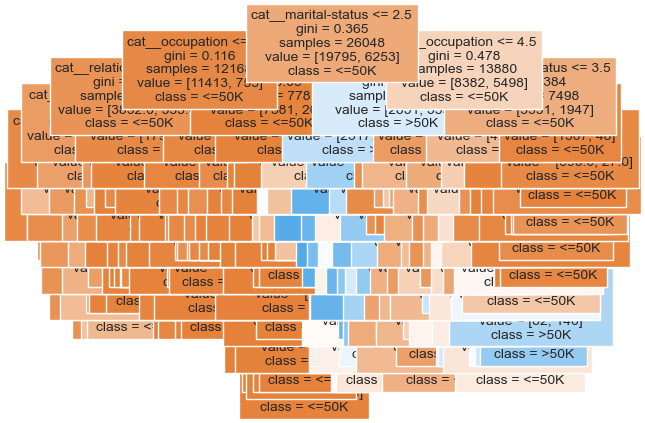

In [75]:

feature_names = pipeline.named_steps["preprocesador"].get_feature_names_out()
plot_tree(pipeline.named_steps['classifier'], filled=True, fontsize=10, feature_names=feature_names, class_names=["<=50K", ">50K"])
plt.savefig("arbol_decision.png",       # nombre y formato
            dpi=300,                    # resolución en puntos por pulgada
            bbox_inches="tight") 
plt.show()

Grid para wrapper

In [ ]:
param_grid = {
    'wrapper__n_features_to_select': [20,25,30, 35, 40],
    'wrapper__step': [1, 3, 5]
}

grid = GridSearchCV(
    estimator=pipeline,  # o pipeline_rfecv
    param_grid=param_grid,
    cv=holdout,
    scoring='roc_auc',
    refit=True,
    n_jobs=-1
)
grid.fit(X, y)

print("Mejor combo:", grid.best_params_)
print("Score CV:", grid.best_score_)


In [ ]:
# import numpy as np
# import pandas as pd
# from scipy.stats import chi2_contingency

# for c in X_transformed.columns:
#     if c in X:  # No es OHE
#         print("")
#     else:
#         contingency_table = pd.crosstab(X_transformed[c], y)  # Tabla de frecuencias

#         chi2, _, _, _ = chi2_contingency(contingency_table)  
#         n = contingency_table.sum().sum()  
#         r, k = contingency_table.shape  

#         if min(r, k) - 1 == 0: #Por si hay una division por cero
#             print("Fallo en ", c, " división por 0")
#             continue
#         q = min(r, k)
#         v = np.sqrt(chi2 / (n * ( q - 1)))  
#         if (v > 0.1):
#             print("La correlacion para ", c, "es de ", v)


Una vez pasadas todas las variables a numericas, podemos ver la matriz de corelacion 

In [ ]:
# X_transformed = binary_transformer.transform(X)
# X_transformed = pd.concat([X_transformed, y], axis=1)
# corr_matrix = X_transformed.corr()
# filtered_corr = corr_matrix.where(corr_matrix != 1)

# plt.figure(figsize=(60,60))
# sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt='.2f')
# plt.show()

Se observan varias correlaciones, algunas obvias como marital-status_Married-civ-spouse con relationship_husband y otras que vamos a analizar. Primero vamos a ver las mas influyentes en el propio resultado
 

In [ ]:
# correlations = X_transformed.corr()['income'].sort_values(ascending=False)
# correlations = abs(correlations).sort_values(ascending=False)
# correlations = correlations.drop('relationship_Husband') 
# correlations = correlations.drop('sex_Male')
# correlations = correlations.drop('sex_Female')


# print("Most influential factors:\n", correlations[:6])

Probamos el rendimiento de nuetro modelo con la metrica seleccionada 

In [77]:
predicciones = pipeline.predict(X)
print("Accuracy:", accuracy_score(y, predicciones))
print("Confusion Matrix:\n", confusion_matrix(y, predicciones))
print("AUC:", roc_auc_score(y, predicciones)) 

Accuracy: 0.831081081081081
Confusion Matrix:
 [[18384  1411]
 [ 2989  3264]]
AUC: 0.7253544093227775


Probamos el rendimiento de nuestro modelo con el test.data que previamente esta dividio por|1x3 Cross validator

In [78]:
#Quitamos el punto final
def transformar_income_test(X): 
    X = X.copy()
    X['income'] = X['income'].str.strip().str.rstrip('.')
    X['income'] = X['income'].map({'<=50K': 0, '>50K': 1})
    return X

data_test = pd.read_csv('src/adult.test', header=None, skiprows=1, sep=',\s', na_values=["?"], engine='python')
data_test.columns = ['age', 'workclass', 'final-weight', 'education', 'education-num', 'marital-status',
                     'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                     'hours-per-week', 'native-country', 'income']

data_test = transformar_income_test(data_test)
X_test, y_test = separar_x_y(data_test)
# X_test_transformed = binary_transformer.transform(X_test)


#Predecimos los valores con el conjunto del test
predicciones_test = pipeline.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, predicciones_test))
print("Test Confusion Matrix:\n", confusion_matrix(y_test, predicciones_test))
print("Test AUC:", roc_auc_score(y_test, predicciones_test))



Test Accuracy: 0.8290031324857196
Test Confusion Matrix:
 [[11610   825]
 [ 1959  1887]]
Test AUC: 0.7121473158081932


SHAP

Globales

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/500 [00:00<?, ?it/s]

C:\Users\alons\anaconda3\envs\py311ml\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\alons\anaconda3\envs\py311ml\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[column] = X[column].astype("object").fillna(np.nan).map(col_mapping)
C:\Users\alons\anaconda3\envs\py311ml\Lib\site-packages\category_encoders\ordinal.py:198: FutureWarning: Downcasting object dtype arrays on .filln

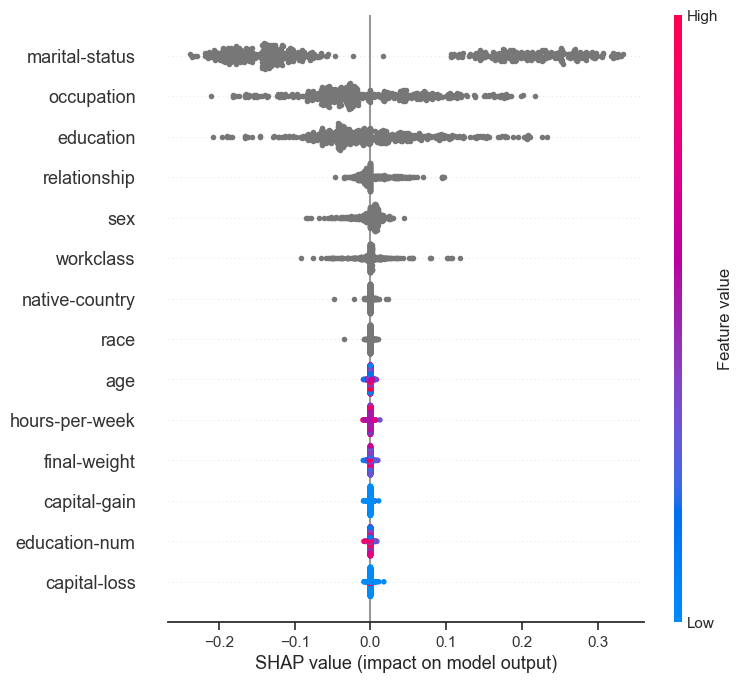

In [79]:
# 1. DataFrames de referencia
feature_names = X.columns

# 2. Función envoltorio
def model_predict(data):
    """Asegura que el Pipeline recibe un DataFrame con los nombres correctos."""
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=feature_names)
    return pipeline.predict_proba(data)[:, 1]

# 3. Background y muestra de evaluación
background = shap.sample(X, 200, random_state=1)     # o shap.kmeans(X, 100)
X_eval     = shap.sample(X, 500, random_state=1)

# 4. Explainer (Kernel o Sampling)
explainer   = shap.KernelExplainer(model_predict, background)
# explainer = shap.SamplingExplainer(model_predict, background)  # algo más rápido

shap_values = explainer.shap_values(X_eval, nsamples=200)

# 5. Gráfico
shap.summary_plot(shap_values, X_eval)


Individuales 

In [80]:
# 0. Solo una vez por notebook
shap.initjs()

# 1. Wrapper para el pipeline  ─ convierte ndarray→DataFrame si hace falta
feature_names = X.columns          # guarda los nombres originales

def model_predict(data):
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data, columns=feature_names)
    return pipeline.predict_proba(data)

# 2. Background pequeño (muestra o k‑means)
background = shap.sample(X, 200, random_state=0)      # o shap.kmeans(X, 100)

# 3. Explainer (Kernel o Sampling) usando la *función*, no el pipeline
explainer = shap.KernelExplainer(model_predict, background)
# explainer = shap.SamplingExplainer(model_predict, background)  # 10 × más rápido

# 4. Fila a explicar
instance = X.iloc[[1]]             # DataFrame de 1 fila

# 5. Cálculo limitado de coaliciones
shap_values = explainer.shap_values(instance, nsamples=200)

# 6. Force plot (clase positiva = 1)
shap.force_plot(
    explainer.expected_value[1],
    shap_values[0,:,0],             # clase 1, primera fila
    instance
)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

Comparativa DT vs KNN con diferentes combinaciones 

In [91]:
#configuraciones
cat_encoders = {
    "OHE"     : OneHotEncoder(handle_unknown="ignore", sparse_output=False),
    "Ordinal" : OrdinalEncoder(handle_unknown="use_encoded_value",
                               unknown_value=-1),
}
if target_ok:
    cat_encoders["Target"] = TargetEncoder(handle_unknown="value",
                                           handle_missing="value")

num_transfs = {
    "None": None,
    "PCA" : PCA(n_components=0.95, svd_solver="full"),
    "Poly": PolynomialFeatures(degree=2, include_bias=False),
}

num_imp = SimpleImputer(strategy="median")
cat_imp = SimpleImputer(strategy="most_frequent")

tabla = []          

def evaluar(modelo, etiqueta):
    modelo.fit(X, y)
    prob = modelo.predict_proba(X_val)[:, 1]
    pred = modelo.predict(X_val)
    tabla.append({
        "Pipeline": etiqueta,
        "Acc":  accuracy_score(y_val, pred),
        "AUC":  roc_auc_score(y_val, prob),
        "Rec":  recall_score(y_val, pred, average="macro")
    })

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()
for enc_name, enc in cat_encoders.items():
    for num_name, num_step in num_transfs.items():

        # numéricas
        steps_num = [("imp", num_imp)]
        if num_step is not None:
            steps_num.append(("tf", num_step))
        steps_num.append(("sc", StandardScaler()))
        num_pipe = Pipeline(steps_num)

        # categóricas
        cat_pipe = Pipeline([("imp", cat_imp), ("enc", enc)])

        preproc = ColumnTransformer([
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols)
        ])

        # Decision Tree
        dt = Pipeline([
            ("prep", preproc),
            ("clf",  DecisionTreeClassifier(max_depth=12,
                                            random_state=42))
        ])
        evaluar(dt, f"DT  {enc_name}-{num_name}")

        #K‑NN
        knn = Pipeline([
            ("prep", preproc),
            ("clf",  KNeighborsClassifier(n_neighbors=11,
                                          weights="distance"))
        ])
        evaluar(knn, f"KNN {enc_name}-{num_name}")

print(f"\n{'Pipeline':25s}  Acc   AUC  Recall")
print("-"*46)
for r in tabla:
    print(f"{r['Pipeline']:25s}  "
          f"{r['Acc']:.3f}  {r['AUC']:.3f}  {r['Rec']:.3f}")



Pipeline                   Acc   AUC  Recall
----------------------------------------------
DT  OHE-None               0.843  0.880  0.781
KNN OHE-None               0.823  0.877  0.741
DT  OHE-PCA                0.811  0.819  0.726
KNN OHE-PCA                0.786  0.818  0.693
DT  OHE-Poly               0.843  0.874  0.759
KNN OHE-Poly               0.839  0.881  0.768
DT  Ordinal-None           0.849  0.871  0.771
KNN Ordinal-None           0.816  0.859  0.725
DT  Ordinal-PCA            0.801  0.802  0.712
KNN Ordinal-PCA            0.785  0.811  0.683
DT  Ordinal-Poly           0.837  0.856  0.770
KNN Ordinal-Poly           0.821  0.866  0.735
DT  Target-None            0.853  0.881  0.769
KNN Target-None            0.832  0.877  0.748
DT  Target-PCA             0.806  0.810  0.703
KNN Target-PCA             0.793  0.824  0.694
DT  Target-Poly            0.844  0.865  0.759
KNN Target-Poly            0.826  0.863  0.734
